In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import networkx as nx
import psycopg2
import psycopg2.extras
import pandas as pd
def pg_get_conn(database="fakenews", user="fakenews", password="fnd"):
    """Get Postgres connection for fakenews

    Returns:
        Connection object : returns Post gres connection object

    Args:
        database (str, optional): Name of database
        user (str, optional): Name of User
        password (str, optional): Password of user
    """
    try:
        conn = psycopg2.connect(database=database,
                                user=user, password=password, host='localhost', port='5432')
        return conn
    except Exception as e:
        print(str(e))
        
def get_next_level_handles(rt=True,table="tweet_articles_tweepy"):
    with pg_get_conn(database="abhishek",user="abhishek",password="vaishu") as conn:
        cur = conn.cursor()
        if rt:
            cur.execute("""Select retweeted_status_user_handle from """+table)
        else:
            cur.execute("""Select * from """+table)
        ans = cur.fetchall()
    lse = set(x[0].replace("{","").replace("}","") for x in ans) if not rt else set(x[0] for x in ans)
    ans_handles=[]
    if not rt:
        for x in lse:
            for y in x.split(","):
                if y != '':
                    ans_handles.append(y)
    else:
        ans_handles = list(lse)
    return(ans_handles)

def run_query(query="""Select * from tweets_cleaned""", realDict = False, arg=None):
    with pg_get_conn(database="abhishek",user="abhishek",password="vaishu") as conn:
        cur = conn.cursor(cursor_factory = psycopg2.extras.RealDictCursor) if realDict else conn.cursor()    
        print(query) if not arg else print(cur.mogrify(query,(arg,)))
        cur.execute(query) if not arg else cur.execute(query,(arg,))
        ans = cur.fetchall()
        return(ans)
def write_next_handles(new_handles):
    path_old_file = '/home/abhishek/Documents/TweetCrawlMultiThreaded/handles.txt'
    old_handles = set()
    with open(path_old_file) as o_handles:
        for o_handle in o_handles:
            if o_handle.startswith('@'):
                o_handle = o_handle.replace('@','')
            old_handles.add(o_handle)
    new_handles = set(new_handles)
    next_level_handles = new_handles.difference(old_handles)
    with open(path_old_file+".bk", 'a') as f:
        for item in old_handles:
            f.write("%s\n" % item)
    with open(path_old_file, 'w') as f:
        for item in next_level_handles:
            f.write("%s\n" % item)

def create_graph(ls_tup):
    G = nx.DiGraph()
    for dc in ls_tup:
        tfrom=dc['tweet_from']
        rt = dc['retweeted_status_user_handle']
        if G.has_edge(tfrom,rt):
            G[tfrom][rt]['weight'] += 1
        else:
            G.add_edge(tfrom,rt,weight=1)
    return(G)

def plot_word_cloud(word_freq_dict,background_color="white", width=800, height=1000,max_words=300, figsize=(50, 50)):
    """
    Display the Word Cloud using Matplotlib
    :param word_freq_dict: Dictionary of word frequencies
    :type word_freq_dict: Dict
    :return: None
    :rtype: None
    """
    word_cloud = WordCloud(background_color=background_color, width=width, height=height,
                           max_words=max_words).generate_from_frequencies(frequencies=word_freq_dict)
    plt.figure(figsize=figsize)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [2]:
n_hand = run_query(query="""select * from tweets_cleaned limit 1000000""")
len(n_hand)

select * from tweets_cleaned limit 1000000


1000000

In [3]:
import pandas as pd
df = pd.DataFrame(n_hand)
df['created_at'] =  pd.to_datetime(df['created_at'])

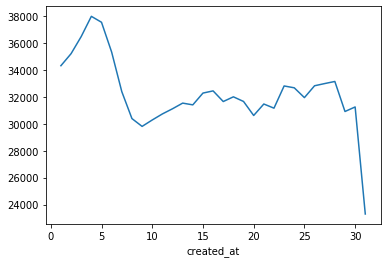

In [4]:
import matplotlib
df.groupby(df.created_at.dt.day).count().id.plot()

In [1]:

from pyspark.sql import SparkSession
# $example on:schema_merging$
from pyspark.sql import Row
# $example off:schema_merging$

In [2]:
spark = SparkSession.builder.appName("Python Spark SQL data source example")
spark.config('spark.executor.memory', '24g')
spark.config('spark.driver.memory','24g')
spark.config('spark.driver.maxResultSize','24g')
spark.config('spark.executor.heartbeatInterval','1000000')
spark.config('spark.network.timeout','1200000')
spark.config('spark.shuffle.partitions', 6)
spark = spark.getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.executor.memory', '24g'),
 ('spark.driver.memory', '24g'),
 ('spark.executor.heartbeatInterval', '1000000'),
 ('spark.driver.maxResultSize', '24g'),
 ('spark.shuffle.partitions', '6'),
 ('spark.driver.host', '192.168.1.2'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'Python Spark SQL data source example'),
 ('spark.driver.port', '45907'),
 ('spark.app.id', 'local-1583269804047'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.network.timeout', '1200000'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
# df = spark.read.jdbc("jdbc:postgresql://localhost:5432/abhishek","tweets_cleaned",properties={"user":"abhishek","password":"vaishu"})
df2 = spark.read.format("jdbc").option("url","jdbc:postgresql://localhost:5432/abhishek").option("dbtable","non_text_cleaned_time")
df2 = df2.option("user","abhishek").option("password","vaishu").option("numPartitions","20")
df2 = df2.load()

TypeError: 'Column' object is not callable

In [8]:
time = df2["created_at"].cast("date")

In [4]:
ls_tup = run_query("select tweet_from,retweeted_status_user_handle from tweets_cleaned where retweeted_status_user_name is not null")

select tweet_from,retweeted_status_user_handle from tweets_cleaned where retweeted_status_user_name is not null


In [19]:
nx.write_gexf(G,"First")

In [2]:
import pandas as pd
ls = run_query("""Select * from non_text_cleaned_time""")
df = pd.DataFrame(ls ,columns = ["time","handle","mentions","retweets","cluster","importance","hashtags"])

NameError: name 'run_query' is not defined

In [3]:
df.to_pickle("mention_retweet_hastags_time.pkl")

In [2]:
import modin.pandas as pd
df  =  pd.read_pickle("mention_retweet_hastags.pkl")

To request implementation, send an email to feature_requests@modin.org.


In [3]:
df.head(5)

NameError: name 'df' is not defined

In [7]:
from collections import Counter
import string
# from nltk.corpus import stopwords 
def __custom_words_accumulator(series):
    c = Counter()
    for sentence in series:
        if sentence:
#             sentence = sentence.lower()  # Convert all text to lower case
#             sentence = sentence.translate(str.maketrans('', '', string.punctuation))  # Remove punctuations
            sent_list = sentence.split(",")
            c.update(sent_list)
    return c.most_common()


wf = df.groupby("cluster")["hashtags"].apply(__custom_words_accumulator)


In [8]:
print(wf[0][:50],wf[1][:50])


[('IndiaSupportsCAA', 23246), ('CAA', 18814), ('India', 15408), ('MannKiBaat', 9442), ('Kashmir', 8858), ('Pakistan', 8508), ('BJP', 8485), ('ShaheenBagh', 8176), ('WATCH', 6924), ('JNU', 6449), ('Delhi', 6236), ('IndianArmy', 5392), ('China', 5241), ('SwachhBharat', 5136), ('Chandrayaan2', 5107), ('LokSabhaElections2019', 5035), ('BREAKING', 5007), ('Congress', 5007), ('MainBhiChowkidar', 4862), ('NRC', 4605), ('Budget2020', 4584), ('TransformingIndia', 4567), ('TeamIndia', 4315), ('RepublicDay', 4296), ('HowdyModi', 4197), ('NewProfilePic', 4167), ('NewIndia', 4016), ('Article370', 3893), ('UrbanNaxals', 3830), ('Maharashtra', 3784), ('MyCleanIndia', 3758), ('Breaking', 3642), ('Modi', 3619), ('ISRO', 3609), ('DelhiElections2020', 3581), ('RahulGandhi', 3557), ('CAB', 3545), ('JammuAndKashmir', 3522), ('PhirEkBaarModiSarkar', 3486), ('CWC19', 3469), ('NarendraModi', 3407), ('CAA2019', 3288), ('MangoNews', 3205), ('ISupportCAA_NRC', 3100), ('CottonIsCool', 3100), ('JaiHind', 3098), ('

In [2]:
wc_dict = pd.DataFrame(wf[1],columns=["handle","freq"])
dct = wc_dict.set_index("handle").to_dict()['freq']
plot_word_cloud(dct

SyntaxError: unexpected EOF while parsing (<ipython-input-2-b05ceeed03c0>, line 3)

In [48]:
wf = wf.reset_index()

In [66]:
wf2

,cluster_id,handle,noOfX
0,0,narendramodi,133692
0,0,BJP4India,68838
0,0,AmitShah,37880
0,0,ANI,33894
0,0,TajinderBagga,29619
...,...,...,...
17,91,JudyGoss,369
17,91,KineticaHQ,368
17,91,WiproDigital,366
17,91,mitsmr,366


In [9]:
import numpy as np
def split_list(series,handleBool=True):
    handles = []
    listNoOfX = []
    for groupList in series:
        for handle,x in groupList:
#             print(handle,x)
            handles.append(handle)
            listNoOfX.append(x)
#     print(listNoOfX)
    if handleBool :
        print("handle")
        return(handles)
    else:
        print("listof")
        return(listNoOfX)
        
wf2 = pd.DataFrame({
    'cluster_id' : np.repeat(wf['cluster'],50),
    'handle': split_list(wf['retweets'],True),
    'noOfX': split_list(wf['retweets'],handleBool=False)
})

KeyError: 'cluster'

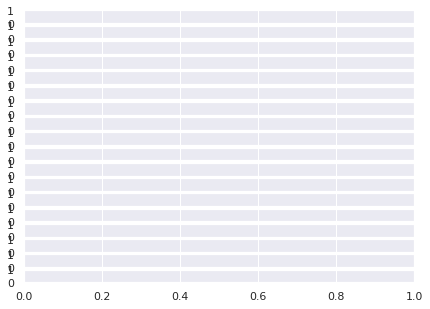

In [65]:
import matplotlib.pyplot as plt
clusters = wf2.cluster_id.unique()


In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize': (40,10)})
i = 0
f, ax = plt.subplots(len(clusters), 1, figsize=(40, 100))
f.tight_layout(pad=6.0)
for cid in clusters:
    g = sns.barplot(x="handle", y="noOfX", hue="cluster_id", data=wf2[wf2.cluster_id==cid],ax=ax[i])
    g.set_xticklabels(g.get_xticklabels(), rotation=50, horizontalalignment='right')
    i+=1

In [30]:
wf2 = wf.reset_index()
wf2[["imp1","imp2","imp3","imp4","imp5"]] = pd.DataFrame(wf2.retweets.values.tolist(), index=wf2.index)

ValueError: Columns must be same length as key

In [10]:
wf2

NameError: name 'wf2' is not defined

In [33]:
df_bjp = pd.DataFrame(wf[1],columns=["handle","mentions"])

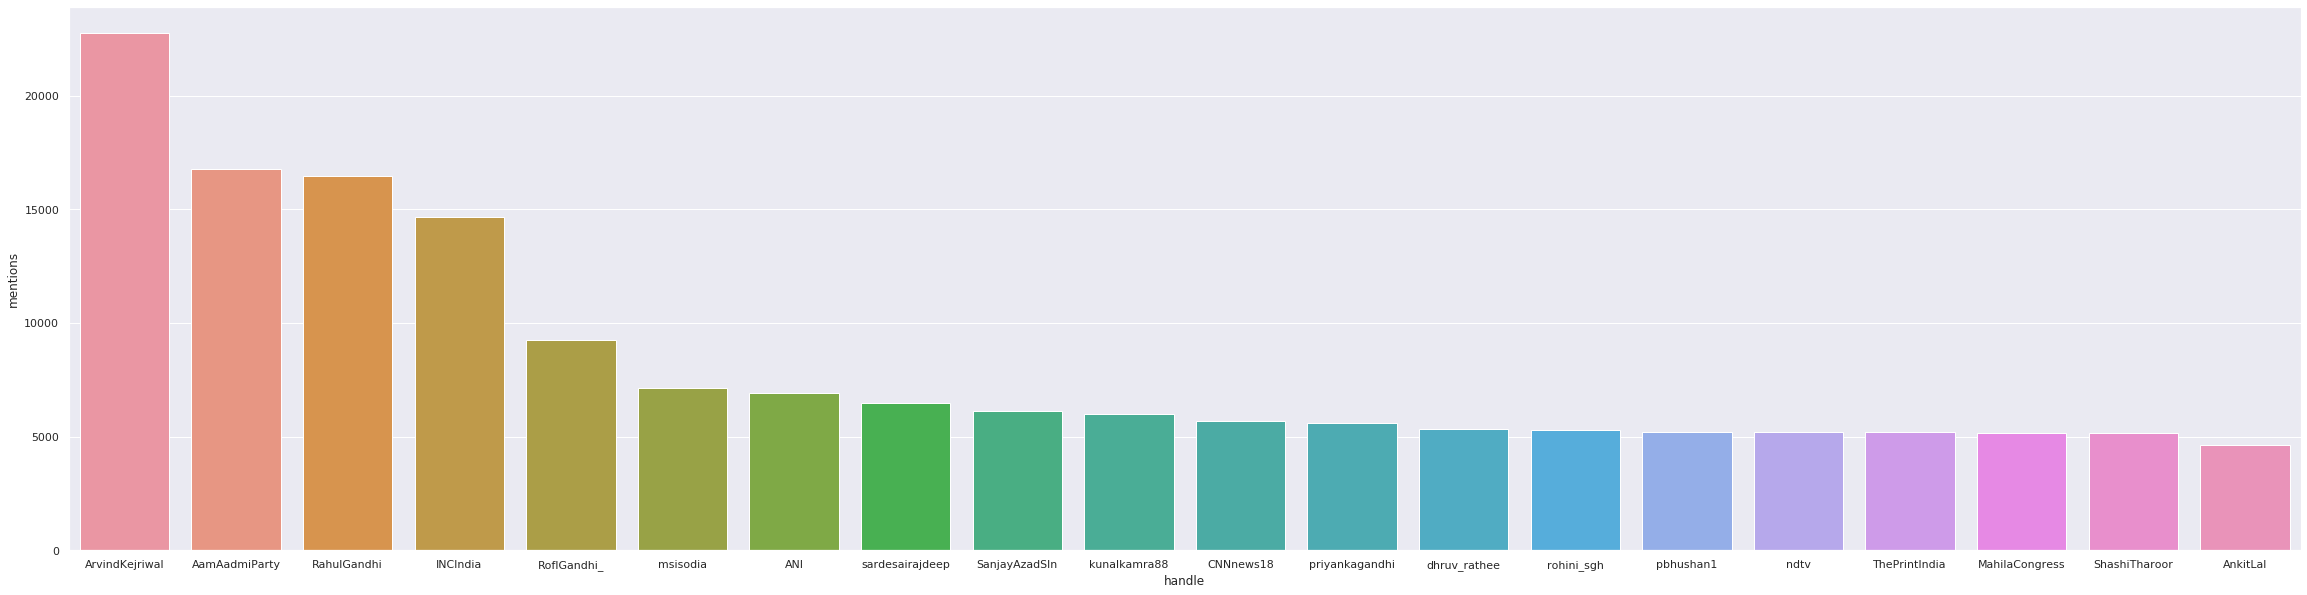

In [34]:
import matplotlib as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (40,10)})
sns.barplot(x="handle",y="mentions",data=df_bjp[0:20])

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def plot_word_cloud(word_freq_dict,background_color="white", width=800, height=1000,max_words=300, figsize=(50, 50)):
    """
    Display the Word Cloud using Matplotlib
    :param word_freq_dict: Dictionary of word frequencies
    :type word_freq_dict: Dict
    :return: None
    :rtype: None
    """
    word_cloud = WordCloud(background_color=background_color, width=width, height=height,
                           max_words=max_words).generate_from_frequencies(frequencies=word_freq_dict)
    plt.figure(figsize=figsize)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
df_bjp = df_bjp.set_index("handle")
dct = df_bjp[:100].to_dict()
plot_word_cloud(dct['mentions'])

{'narendramodi': 450447,
 'BJP4India': 166741,
 'AmitShah': 152910,
 'PMOIndia': 84858,
 'ArvindKejriwal': 67572,
 'RahulGandhi': 67536,
 'INCIndia': 61059,
 'ANI': 60815,
 'TajinderBagga': 57294,
 'Swamy39': 55778,
 'myogiadityanath': 51966,
 'KapilMishra_IND': 43007,
 'aajtak': 39487,
 'PiyushGoyal': 35313,
 'TimesNow': 34293,
 'ShefVaidya': 33681,
 'vivekagnihotri': 33579,
 'sardanarohit': 31139,
 'ChouhanShivraj': 30037,
 'ZeeNewsHindi': 29396,
 'republic': 27554,
 'Dev_Fadnavis': 27188,
 'JPNadda': 25527,
 'BDUTT': 24627,
 'sambitswaraj': 24598,
 'ippatel': 23484,
 'sardesairajdeep': 23064,
 'nsitharaman': 23014,
 'IndiaToday': 22944,
 'rajnathsingh': 22792,
 'smritiirani': 22691,
 'sudhirchaudhary': 22499,
 'BJP4Delhi': 21830,
 'TarekFatah': 21336,
 'AskAnshul': 20483,
 'ndtv': 19230,
 'Uppolice': 19075,
 'OpIndia_com': 18667,
 'rishibagree': 18247,
 'DrKumarVishwas': 18214,
 'ZeeNews': 18207,
 'Real_Anuj': 18075,
 'MajorPoonia': 17794,
 'amitmalviya': 17514,
 'ManojTiwariMP': 17

In [37]:
df_bjp

,mentions
handle,
narendramodi,450447
BJP4India,166741
AmitShah,152910
PMOIndia,84858
ArvindKejriwal,67572
...,...
_jgranger,1
JustDoBig,1
Radeon,1


In [4]:
# import modin.pandas as pd
# df  =  pd.read_pickle("mention_retweet_hastags_time.pkl")
import pandas as pd
ls = run_query("""Select * from non_text_cleaned_time""")
df = pd.DataFrame(ls ,columns = ["time","handle","mentions","retweets","cluster","importance","hashtags"])
df['time'] = pd.to_datetime(df['time'], format="%a %b %d %H:%M:%S %z %Y")
df.to_pickle("mention_retweet_hastags_timeobj.pkl")

Select * from non_text_cleaned_time


In [20]:
%timeit pd.to_datetime(df['time'][0])

356 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [21]:
%timeit pd.to_datetime(df['time'][0], infer_datetime_format=True)

941 µs ± 7.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%timeit pd.to_datetime(df['time'][0], format="%a %b %d %H:%M:%S %z %Y")

402 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
df['time'] = 

SyntaxError: invalid syntax (<ipython-input-10-e1d64b4ec7b8>, line 1)

In [24]:
pd.to_datetime(df['time'][0])

Timestamp('2014-04-01 13:32:33+0000', tz='UTC')

In [23]:
pd.to_datetime(df['time'][0], format="%a %b %d %H:%M:%S %z %Y")

Timestamp('2014-04-01 13:32:33+0000', tz='UTC')

In [9]:
df_daily = df.groupby(df.time.dt.day)

In [18]:
df_date = df.groupby(df.time.dt.date)

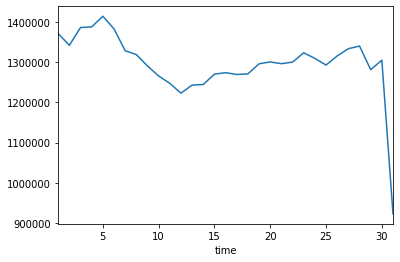

In [17]:
df_daily.describe()["cluster"]["count"].plot()

In [20]:
df_date.describe()

cluster                                                      \
               count       mean        std   min   25%   50%   75%   max   
time                                                                       
2007-04-18       1.0  91.000000        NaN  91.0  91.0  91.0  91.0  91.0   
2007-04-19       1.0  91.000000        NaN  91.0  91.0  91.0  91.0  91.0   
2007-04-20       3.0  76.333333  25.403412  47.0  69.0  91.0  91.0  91.0   
2007-04-26       1.0  91.000000        NaN  91.0  91.0  91.0  91.0  91.0   
2007-05-03       1.0  47.000000        NaN  47.0  47.0  47.0  47.0  47.0   
...              ...        ...        ...   ...   ...   ...   ...   ...   
2020-02-07  126386.0  24.025114  25.229783   0.0   3.0  14.0  43.0  91.0   
2020-02-08   97468.0  24.371035  25.291911   0.0   3.0  14.0  43.0  91.0   
2020-02-09   73325.0  25.305626  25.781489   0.0   3.0  14.0  43.0  91.0   
2020-02-10   48277.0  25.815274  26.529867   0.0   3.0  14.0  43.0  91.0   
2020-02-11   11117.0  24.362328  26.653043   0.0   3.0   8.0  43.0  91.0   

           importance                                                        \
                count         mean         std    min    25%    50%     75%   
time                                                                          
2007-04-18        1.0     6.000000         NaN    6.0    6.0    6.0     6.0   
2007-04-19        1.0     6.000000         NaN    6.0    6.0    6.0     6.0   
2007-04-20        3.0   105.333333  172.050380    6.0    6.0    6.0   155.0   
2007-04-26        1.0     6.000000         NaN    6.0    6.0    6.0     6.0   
2007-05-03        1.0   202.000000         NaN  202.0  202.0  202.0   202.0   
...               ...          ...         ...    ...    ...    ...     ...   
2020-02-07   126386.0  1135.093539  867.459523    2.0  394.0  899.0  1884.0   
2020-02-08    97468.0  1121.259316  851.062539    2.0  386.0  890.0  1873.0   
2020-02-09    73325.0  1044.248415  818.803958    2.0  350.0  819.0  1684.0   
2020-02-10    48277.0  1037.963109  823.110695    2.0  339.0  814.0  1696.0   
2020-02-11    11117.0  1064.504543  843.376110    2.0  381.0  818.0  1716.0   

                    
               max  
time                
2007-04-18     6.0  
2007-04-19     6.0  
2007-04-20   304.0  
2007-04-26     6.0  
2007-05-03   202.0  
...            ...  
2020-02-07  7210.0  
2020-02-08  5080.0  
2020-02-09  5080.0  
2020-02-10  5080.0  
2020-02-11  3395.0  

[4471 rows x 16 columns]

In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get
df = pd.read_pickle("mention_retweet_hastags_timeobj.pkl")

In [10]:
from collections import Counter
def agg_func(series):
    c = Counter()
    for x in c:
        print(x)
        c.update(x)
    return c.most_common()
    

df_date = df.groupby(df.time.dt.date)
ddata = dd.from_pandas(df_date,npartitions=12)
res = ddata.map_partitions(lambda df: df.apply((lambda row: agg_func(*row)))).compute(get=get)

TypeError: Input must be a pandas DataFrame or Series

In [29]:
ddata = dd.from_pandas(df,npartitions=12)
dateddata.groupby(ddata.time.dt.date)

NameError: name 'dateddata' is not defined

In [7]:
from collections import Counter
c = Counter()
c.update([1,2,3,4,1,2,1,1])

dict(c.most_common())

{1: 4, 2: 2, 3: 1, 4: 1}

In [25]:
from collections import Counter
def agg_func1(series):
    c = Counter()
    c.update(series.to_list())
    return pd.Series(dict(c.most_common()))
res = ddata.groupby(ddata.time.dt.hour).cluster.apply(agg_func1).compute()

/home/abhishek/Documents/python-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  


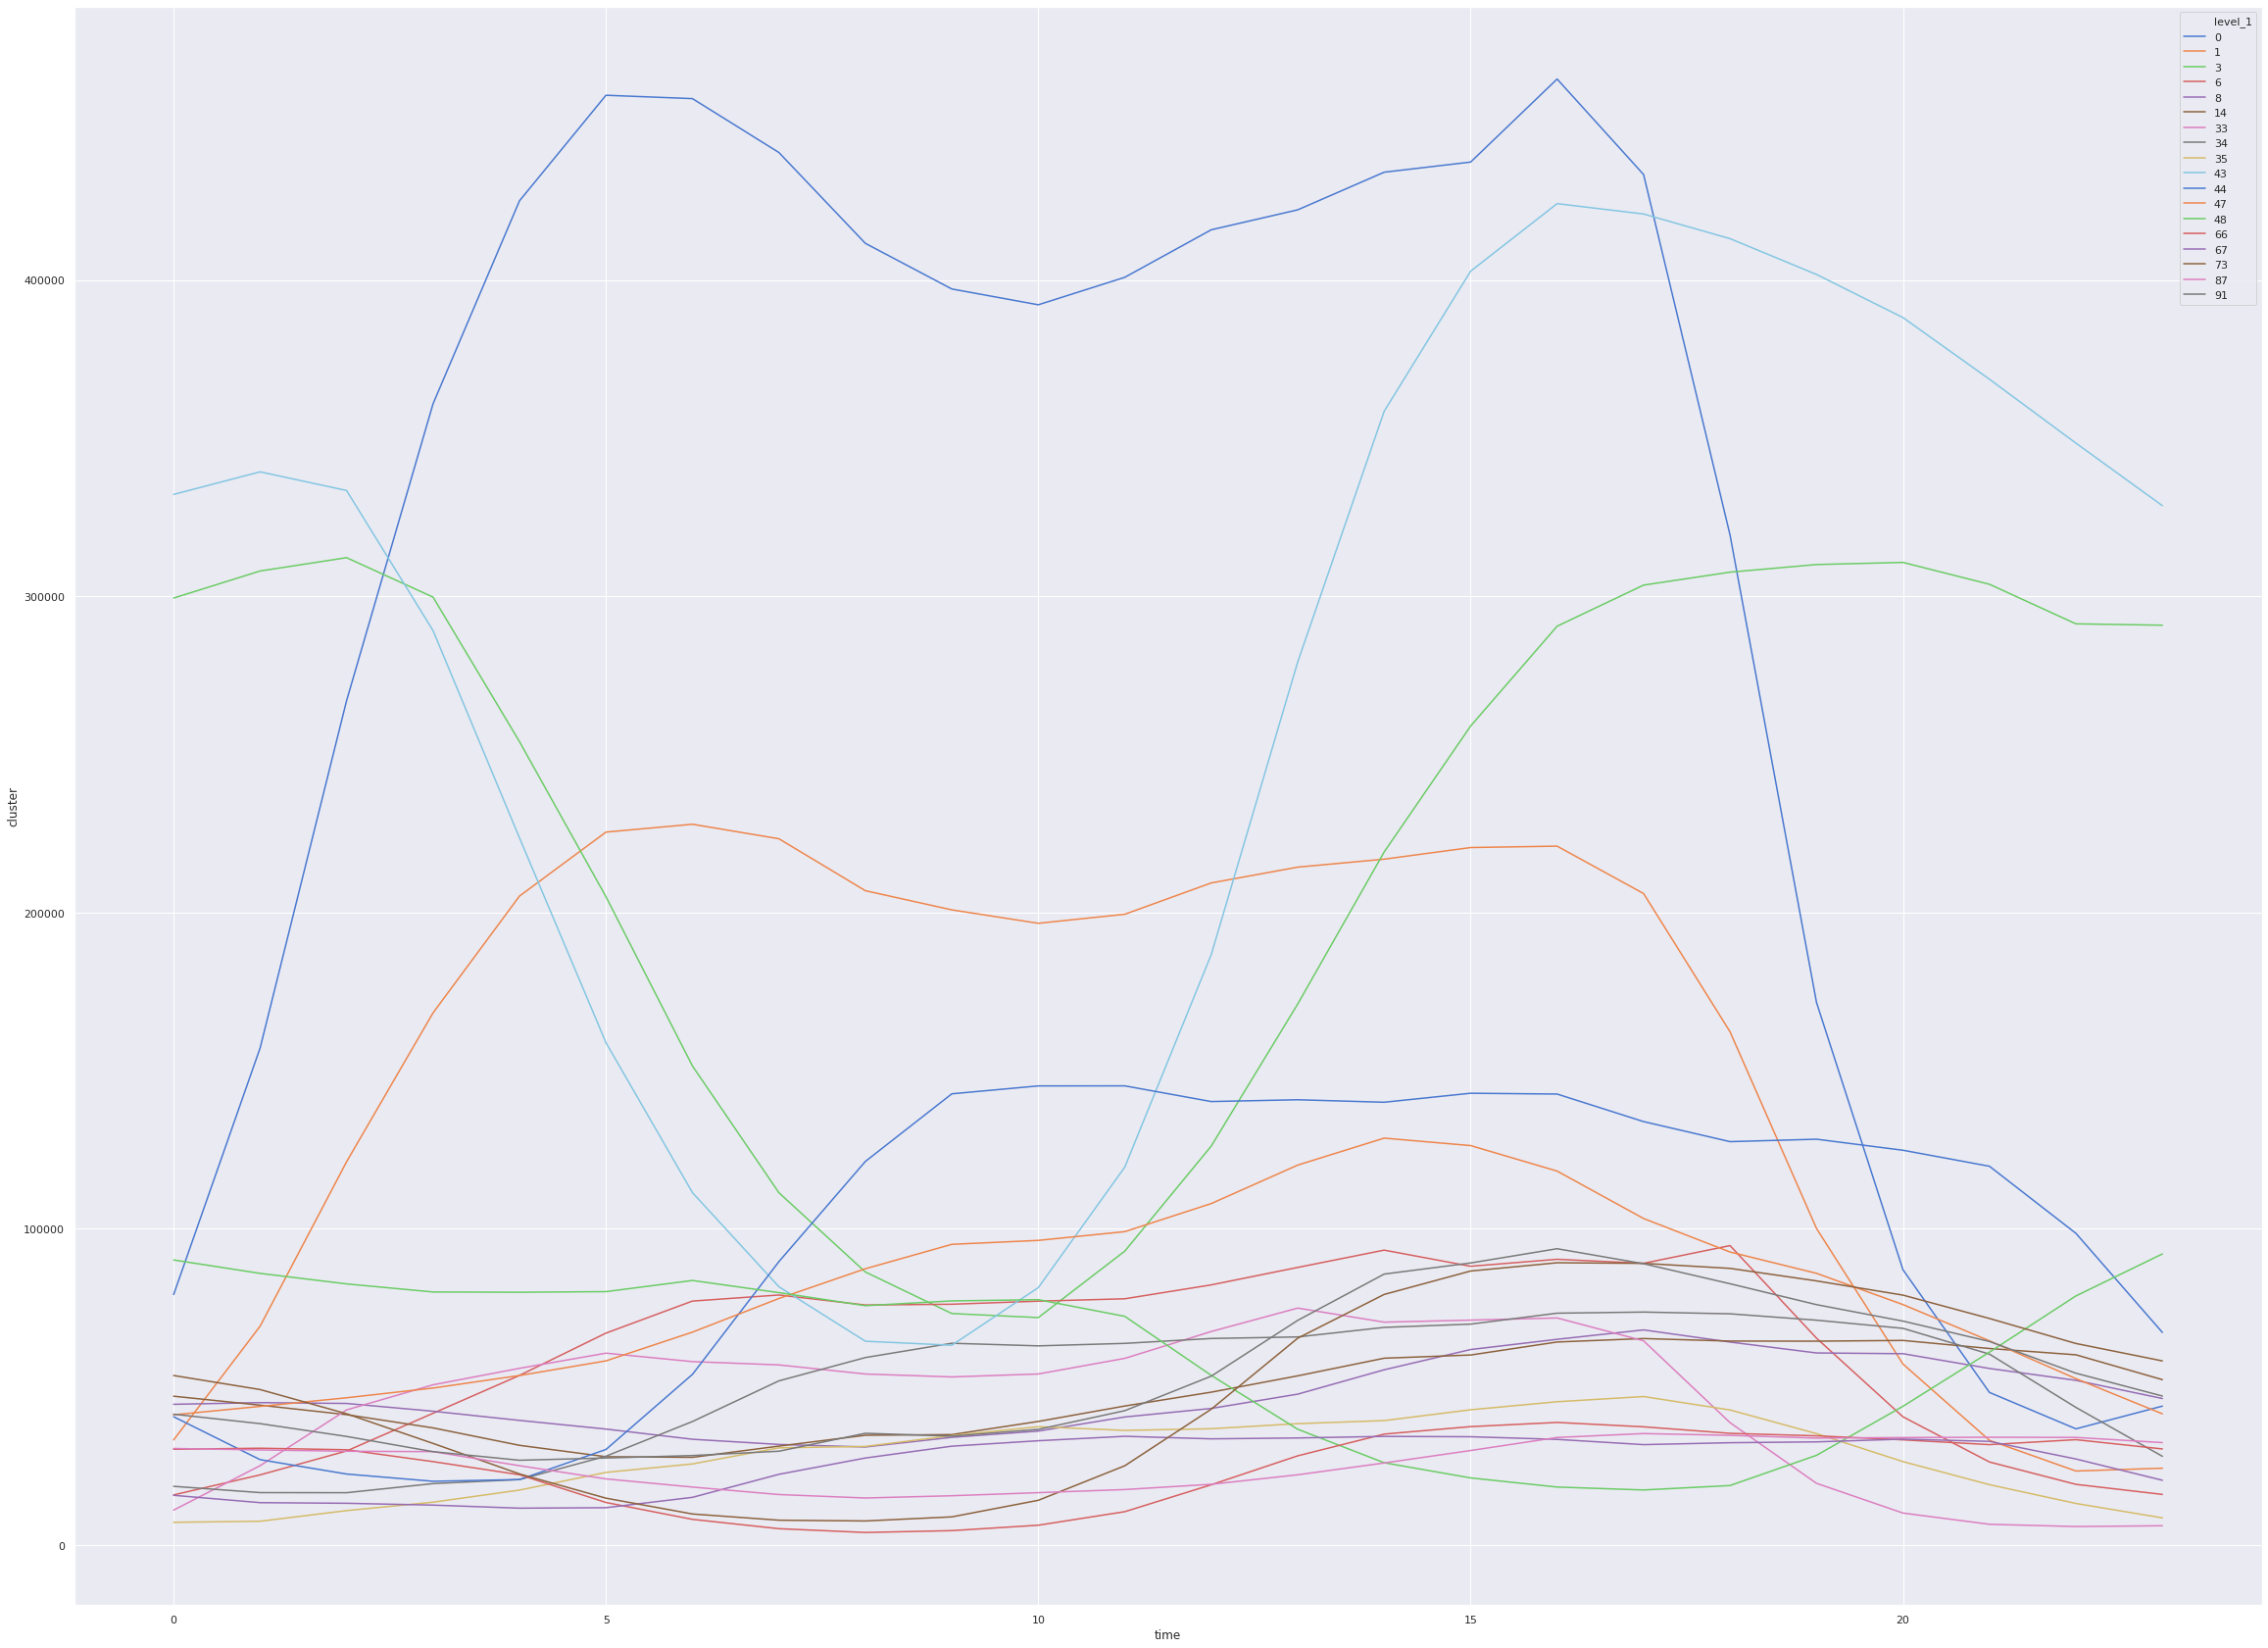

In [28]:
import seaborn as sns
sns.set(rc={'figure.figsize': (40,30)})
sns.lineplot(x="time",hue="level_1",y="cluster",data=res.reset_index(),legend="full",palette=sns.color_palette("muted",len(res.reset_index().level_1.unique())))

In [6]:
ls = run_query("SELECT t.tweet_from,t.user_mentions_name,t.retweeted_status_user_handle,t.hashtags,c.cluster,c.importance FROM tweet_articles_tweepy AS t INNER JOIN cluster_mapping AS c ON t.tweet_from = c.id WHERE c.cluster in (36041,65124)")


SELECT t.tweet_from,t.user_mentions_name,t.retweeted_status_user_handle,t.hashtags,c.cluster,c.importance FROM tweet_articles_tweepy AS t INNER JOIN cluster_mapping AS c ON t.tweet_from = c.id WHERE c.cluster in (36041,65124)


In [11]:
ls[-10:]

[('Lisaraniray', '{}', None, '{}', 65124, 0.005226),
 ('Lisaraniray',
  '{4moreshotspls,PankajandNidhi,aastha06}',
  None,
  '{hcraftjewellery,astylistascloset}',
  65124,
  0.005226),
 ('Lisaraniray', '{kaysarahsera}', 'kaysarahsera', '{}', 65124, 0.005226),
 ('Lisaraniray', '{kristatippett}', 'kristatippett', '{}', 65124, 0.005226),
 ('Lisaraniray',
  '{PrimeVideoIN}',
  None,
  '{4ShotsMorePlease,Dehni}',
  65124,
  0.005226),
 ('Lisaraniray', '{}', None, '{}', 65124, 0.005226),
 ('Lisaraniray',
  '{Lisaraniray}',
  'nnis_sports',
  '{BollywoodNews}',
  65124,
  0.005226),
 ('Lisaraniray',
  '{4moreshotspls,PrimeVideoIN}',
  None,
  '{Mumbai}',
  65124,
  0.005226),
 ('Lisaraniray',
  '{PrimeVideoIN,RangitaNandy,PritishNandyCom}',
  None,
  '{4ShotsMorePlease,womensupportingwomen}',
  65124,
  0.005226),
 ('Lisaraniray',
  '{Lisaraniray,Mint_Lounge}',
  'DiyaKar73',
  '{ClosetotheBone}',
  65124,
  0.005226)]

In [26]:
df = pd.DataFrame(ls,columns=['handle','mentions','retweets','hashtags','cluster','importance'])
df.head()

,handle,mentions,retweets,hashtags,cluster,importance
0,@HRDMinistry,{DrRPNishank},None,{DestinationIndia},36041,0.0
1,@HRDMinistry,{},None,{},36041,0.0
2,@HRDMinistry,{DrRPNishank},None,"{NAAC,NewDelhi,education,EducationForAll}",36041,0.0
3,@HRDMinistry,{IITKanpur},None,{},36041,0.0
4,@HRDMinistry,{},None,"{ShaalaSiddhi,education,InitiativesofMHRD}",36041,0.0


In [28]:
df['hashtags']=df.hashtags.replace('{}',None)
df['hashtags']=df.hashtags.str.lstrip('{')
df['hashtags']=df.hashtags.str.rstrip('}')

,handle,mentions,retweets,hashtags,cluster,importance
0,@HRDMinistry,DrRPNishank,None,DestinationIndia,36041,0.0
1,@HRDMinistry,DrRPNishank,None,DestinationIndia,36041,0.0
2,@HRDMinistry,DrRPNishank,None,"NAAC,NewDelhi,education,EducationForAll",36041,0.0
3,@HRDMinistry,IITKanpur,None,"NAAC,NewDelhi,education,EducationForAll",36041,0.0
4,@HRDMinistry,IITKanpur,None,"ShaalaSiddhi,education,InitiativesofMHRD",36041,0.0


In [29]:
df[-10:]

,handle,mentions,retweets,hashtags,cluster,importance
20820080,Lisaraniray,PicoIyer,None,FourMoreShotsPlease,65124,0.005226
20820081,Lisaraniray,"4moreshotspls,PankajandNidhi,aastha06",None,"hcraftjewellery,astylistascloset",65124,0.005226
20820082,Lisaraniray,kaysarahsera,kaysarahsera,"hcraftjewellery,astylistascloset",65124,0.005226
20820083,Lisaraniray,kristatippett,kristatippett,"hcraftjewellery,astylistascloset",65124,0.005226
20820084,Lisaraniray,PrimeVideoIN,None,"4ShotsMorePlease,Dehni",65124,0.005226
20820085,Lisaraniray,PrimeVideoIN,None,"4ShotsMorePlease,Dehni",65124,0.005226
20820086,Lisaraniray,Lisaraniray,nnis_sports,BollywoodNews,65124,0.005226
20820087,Lisaraniray,"4moreshotspls,PrimeVideoIN",None,Mumbai,65124,0.005226
20820088,Lisaraniray,"PrimeVideoIN,RangitaNandy,PritishNandyCom",None,"4ShotsMorePlease,womensupportingwomen",65124,0.005226
20820089,Lisaraniray,"Lisaraniray,Mint_Lounge",DiyaKar73,ClosetotheBone,65124,0.005226


In [30]:
df.to_pickle('pickles/mention_retweet_hastags2.pkl')

In [3]:
import datetime
CLUSTERS_OF_INTEREST = [36041,65124]

def update_MRH_TIME_PKL(suffix=str(datetime.datetime.now())):
    ls = run_query("SELECT t.created_at,t.tweet_from,t.user_mentions_name,t.retweeted_status_user_handle,t.hashtags,c.cluster,c.importance FROM tweet_articles_tweepy AS t INNER JOIN cluster_mapping AS c ON t.tweet_from = c.id WHERE c.cluster in %s",arg=tuple(CLUSTERS_OF_INTEREST))
    df = pd.DataFrame(ls ,columns = ["time","handle","mentions","retweets","hashtags","cluster","importance"])
    df['time'] = pd.to_datetime(df['time'], format="%a %b %d %H:%M:%S %z %Y")
    for x in ['mentions','hashtags']:
        df[x]=df[x].replace('{}',None)
        df[x]=df[x].str.lstrip('{')
        df[x]=df[x].str.rstrip('}')
    MRH_TIME_FILE_PATH = 'pickles/mention_retweet_hastags_timeobj(%s).pkl'.format(suffix) 
    df.to_pickle(MRH_TIME_FILE_PATH)
    return df
update_MRH_TIME_PKL(2)

b'SELECT t.created_at,t.tweet_from,t.user_mentions_name,t.retweeted_status_user_handle,t.hashtags,c.cluster,c.importance FROM tweet_articles_tweepy AS t INNER JOIN cluster_mapping AS c ON t.tweet_from = c.id WHERE c.cluster in (36041, 65124)'


,time,handle,mentions,retweets,hashtags,cluster,importance
0,2020-01-28 17:01:43+00:00,iSunnySharma22,sambitswaraj,sambitswaraj,,36041,0.000157
1,2020-01-28 17:00:56+00:00,iSunnySharma22,ANI,ANI,,36041,0.000157
2,2020-01-28 17:00:01+00:00,iSunnySharma22,"moronhumor,kunalkamra88",moronhumor,,36041,0.000157
3,2020-01-28 09:11:05+00:00,iSunnySharma22,"JPNadda,AmitShah,narendramodi,PavanRanaRSS,jai...",None,"IsupportCAA,IndiaSupportsCAA,ChandigarhSupport...",36041,0.000157
4,2020-01-28 09:09:28+00:00,iSunnySharma22,"JPNadda,AmitShah,narendramodi,PavanRanaRSS,jai...",None,"IsupportCAA,IndiaSupportsCAA,ChandigarhSupport...",36041,0.000157
...,...,...,...,...,...,...,...
20820085,2018-02-09 09:45:23+00:00,TOIBhubaneswar,"Naveen_Odisha,TOICitiesNews",None,CustodialDeath,36041,0.000878
20820086,2018-02-09 07:06:18+00:00,TOIBhubaneswar,"Naveen_Odisha,TOICitiesNews",None,CustodialDeath,36041,0.000878
20820087,2018-02-09 07:06:02+00:00,TOIBhubaneswar,"Naveen_Odisha,TOICitiesNews",None,CustodialDeath,36041,0.000878
20820088,2018-02-09 06:37:35+00:00,TOIBhubaneswar,"Naveen_Odisha,TOICitiesNews",None,CustodialDeath,36041,0.000878


In [7]:
suffix ="xming"
'pickles/mention_retweet_hastags_timeobj{0}.pkl'.format(suffix) 

'pickles/mention_retweet_hastags_timeobjxming.pkl'